## **LunarLander RL Analysis Notebook**

This notebook provides comprehensive analysis of the trained reinforcement learning agent including:
- Training metrics visualization
- Performance analysis
- Hyperparameter sensitivity
- Action distribution analysis

### LunarLander RL Analysis
**This notebook analyzes the performance of our trained DQN/ DDQN agent.**

In [1]:
# Setup
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import torch
import gymnasium as gym

from agent import DQNAgent
from config import DQNConfig

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)

### Configuration and paths

In [2]:
# Update it with the specific run you want to analyze
RUN_FOLDER = "double_dqn_20260227_1602"
BASE_MODEL_DIR = f"./models/{RUN_FOLDER}"
HISTORY_PATH = f"{BASE_MODEL_DIR}/training_history.json"
MODEL_PATH = f"{BASE_MODEL_DIR}/best_model.pth"

# Ensure output directories exist
os.makedirs("/docs/images", exist_ok=True)
os.makedirs("./docs/notebooks", exist_ok=True)
os.makedirs("./plots", exist_ok=True)

### Load Data

In [3]:
# Load Training History
with open(HISTORY_PATH, "r") as f:
    history = json.load(f)

episode_rewards = history["episode_rewards"]
moving_avg_rewards = history["moving_avg_rewards"]
episode_losses = history["episode_losses"]

print(f"🚀 Analysis for Run: {RUN_FOLDER}")
print(f"Total episodes: {len(episode_rewards)}")
print(f"Best average reward: {history['best_avg_reward']:.2f}")
print(f"Training date: {history.get('training_date', 'N/A')}")

🚀 Analysis for Run: double_dqn_20260227_1602
Total episodes: 2000
Best average reward: 269.48
Training date: 2026-02-27T16:25:57.076701


### Training Curves

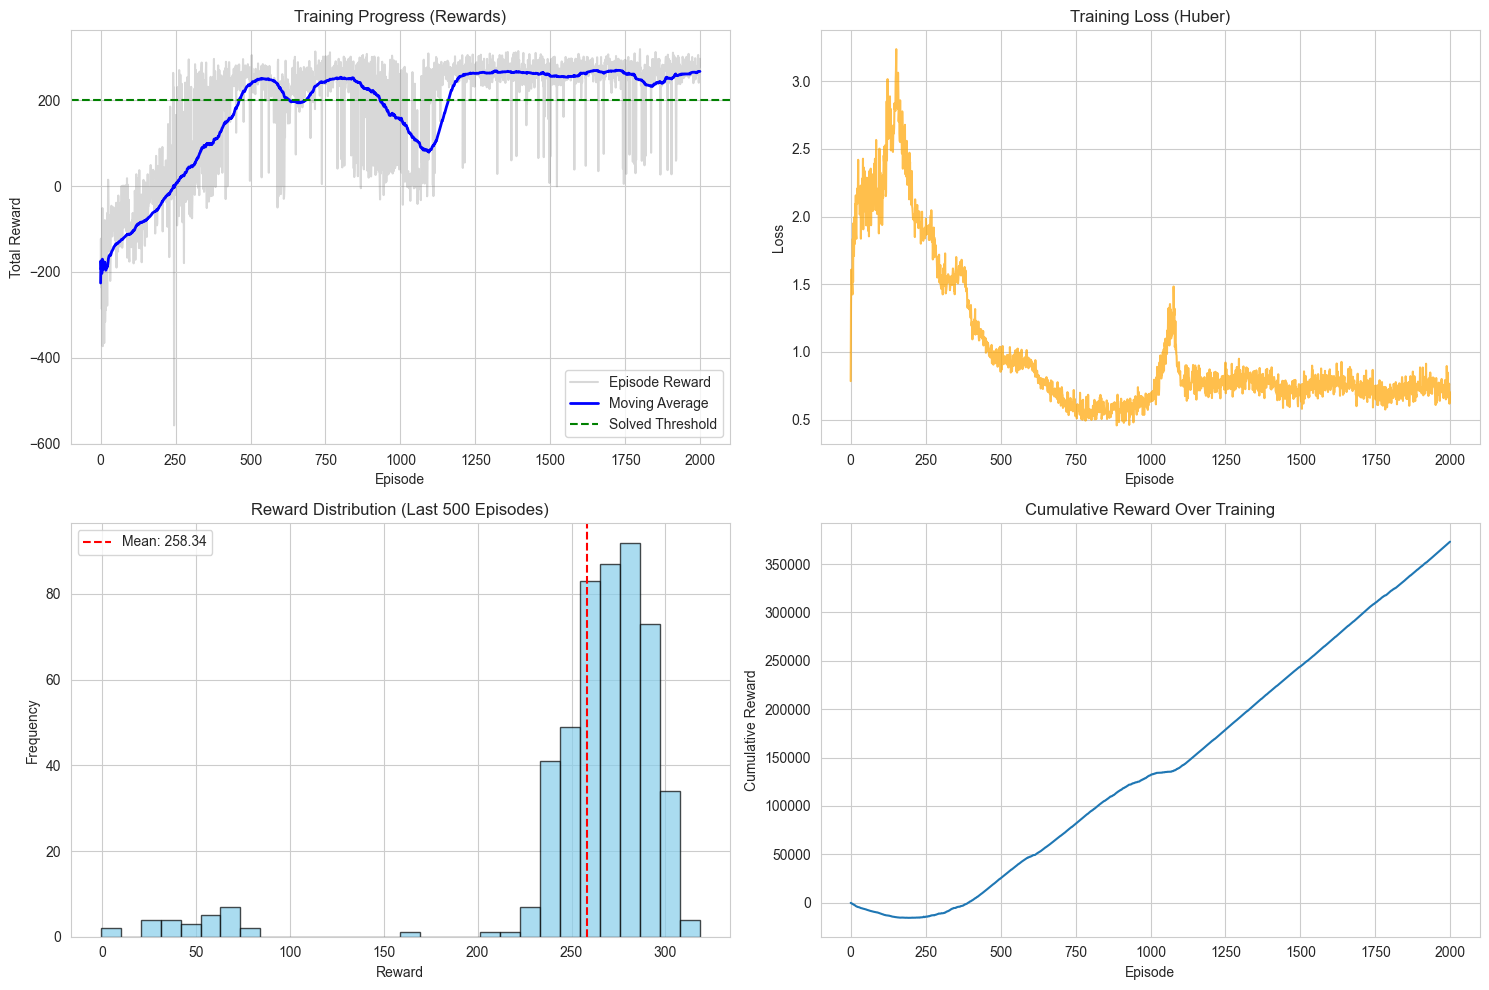

In [5]:
# Plot Training Curves
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
# Reward curve
axes[0, 0].plot(episode_rewards, alpha=0.3, color='gray', label="Episode Reward")
axes[0, 0].plot(moving_avg_rewards, linewidth=2, color='blue', label="Moving Average")
axes[0, 0].axhline(y=200, color="green", linestyle="--", label="Solved Threshold")
axes[0, 0].set_xlabel("Episode")
axes[0, 0].set_ylabel("Total Reward")
axes[0, 0].set_title("Training Progress (Rewards)")
axes[0, 0].legend()
axes[0, 0].grid(True)

# Loss curve
axes[0, 1].plot(episode_losses, alpha=0.7, color="orange")
axes[0, 1].set_xlabel("Episode")
axes[0, 1].set_ylabel("Loss")
axes[0, 1].set_title("Training Loss (Huber)")
# axes[0, 1].set_yscale('log')
axes[0, 1].grid(True)

# Reward distribution (last 500 episodes)
recent_rewards = episode_rewards[-500:]
axes[1, 0].hist(recent_rewards, bins=30, alpha=0.7, color="skyblue", edgecolor="black")
axes[1, 0].axvline(
    np.mean(recent_rewards),
    color="red",
    linestyle="--",
    label=f"Mean: {np.mean(recent_rewards):.2f}",
)
axes[1, 0].set_xlabel("Reward")
axes[1, 0].set_ylabel("Frequency")
axes[1, 0].set_title("Reward Distribution (Last 500 Episodes)")
axes[1, 0].legend()
axes[1, 0].grid(True)

# Cumulative reward
cumulative_rewards = np.cumsum(episode_rewards)
axes[1, 1].plot(cumulative_rewards)
axes[1, 1].set_xlabel("Episode")
axes[1, 1].set_ylabel("Cumulative Reward")
axes[1, 1].set_title("Cumulative Reward Over Training")
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig("./docs/images/comprehensive_analysis.png", dpi=300, bbox_inches="tight")
plt.show();

Performance Statistics

In [6]:
def calculate_stats(rewards, window=100):
    """Calculate rolling statistics."""
    stats = {
        "mean": np.mean(rewards),
        "std": np.std(rewards),
        "min": np.min(rewards),
        "max": np.max(rewards),
        "success_rate": np.mean(np.array(rewards) >= 200) * 100,
    }
    return stats


# Overall statistics
overall_stats = calculate_stats(episode_rewards)
print("\n" + "=" * 50)
print("Overall Training Statistics")
print("=" * 50)
for key, value in overall_stats.items():
    if key == "success_rate":
        print(f"{key}: {value:.2f}%")
    else:
        print(f"{key}: {value:.2f}")

# Last 500 episodes statistics
recent_stats = calculate_stats(episode_rewards[-500:])
print("\n" + "=" * 50)
print("Recent Performance (Last 500 Episodes)")
print("=" * 50)
for key, value in recent_stats.items():
    if key == "success_rate":
        print(f"{key}: {value:.2f}%")
    else:
        print(f"{key}: {value:.2f}")


Overall Training Statistics
mean: 186.60
std: 130.75
min: -556.82
max: 318.36
success_rate: 70.30%

Recent Performance (Last 500 Episodes)
mean: 258.34
std: 53.74
min: -0.72
max: 318.36
success_rate: 94.40%


In [7]:
# Learning Phases Analysis
def identify_learning_phases(rewards, threshold=200):
    """Identify when the agent starts consistently solving the task."""
    moving_avg = np.convolve(rewards, np.ones(100) / 100, mode="valid")
    solved_episode = np.argmax(moving_avg >= threshold)
    return solved_episode


solved_at = identify_learning_phases(episode_rewards)
print(f"\nAgent solved the environment at episode: {solved_at}")
print(f"Time to solve: {solved_at} episodes")


Agent solved the environment at episode: 364
Time to solve: 364 episodes


Action Distribution Analysis (requires running evaluation)

In [8]:
print("\n" + "=" * 50)
print("Action Distribution Analysis")
print("=" * 50)
print("Run evaluate.py with action tracking to analyze action distribution")


Action Distribution Analysis
Run evaluate.py with action tracking to analyze action distribution


### Q-Value Distribution Analysis

Using device: cpu

Computing Q-value distributions for 1000 random states...


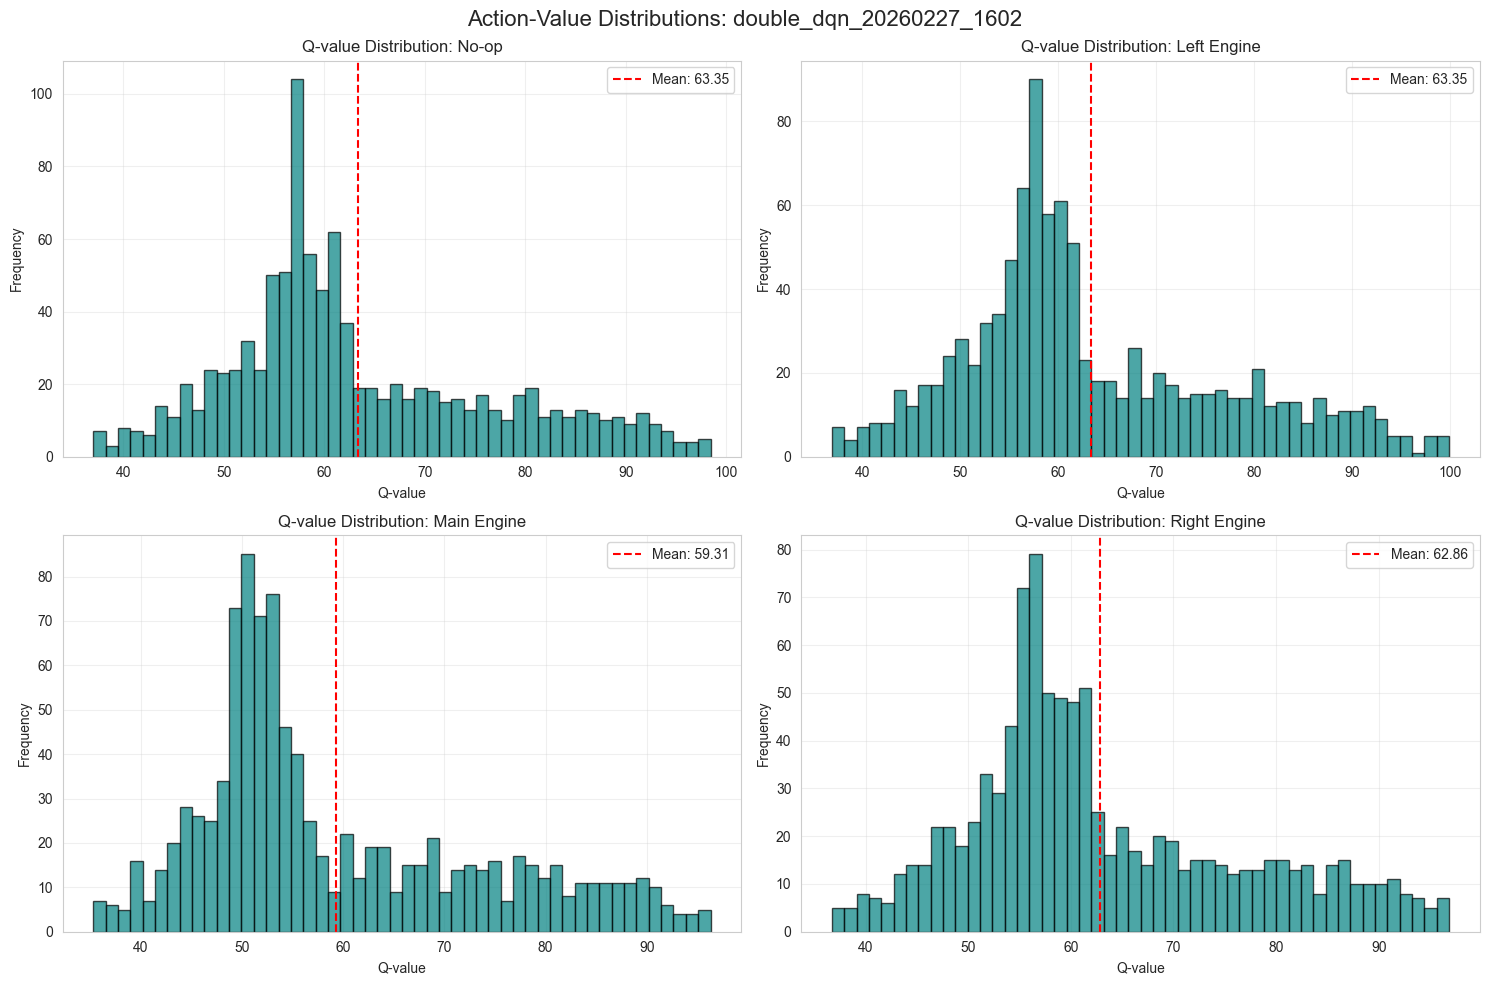


✅ Analysis complete for double_dqn_20260227_1602!


In [9]:
env = gym.make("LunarLander-v2")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Initialize agent with dims
agent = DQNAgent(state_dim=state_dim, action_dim=action_dim, config=DQNConfig())
agent.load(MODEL_PATH)
agent.policy_net.eval()

# Sample states and compute Q-values
num_samples = 1000
print(f"\nComputing Q-value distributions for {num_samples} random states...")
q_values_list = []

for _ in range(num_samples):
    state, _ = env.reset()
    with torch.no_grad():
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(agent.device)
        q_values = agent.policy_net(state_tensor).cpu().numpy()[0]
        q_values_list.append(q_values)

q_values_array = np.array(q_values_list)

# Plot Q-value distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
action_names = ["No-op", "Left Engine", "Main Engine", "Right Engine"]

for i, (ax, name) in enumerate(zip(axes.flat, action_names)):
    ax.hist(q_values_array[:, i], bins=50, alpha=0.7, color="teal", edgecolor="black")
    ax.set_xlabel("Q-value")
    ax.set_ylabel("Frequency")
    ax.set_title(f"Q-value Distribution: {name}")
    ax.axvline(
        np.mean(q_values_array[:, i]),
        color="red",
        linestyle="--",
        label=f"Mean: {np.mean(q_values_array[:, i]):.2f}",
    )
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle(f"Action-Value Distributions: {RUN_FOLDER}", fontsize=16)
plt.tight_layout()
plt.savefig(f"./plots/q_value_{RUN_FOLDER}", dpi=300, bbox_inches="tight")
plt.show()

# Export Summary
def calculate_stats_(rewards):
    return {
        "mean": float(np.mean(rewards)),
        "success_rate": float(np.mean(np.array(rewards) >= 200) * 100),
        "max": float(np.max(rewards))
    }
    
overall_stats_ = calculate_stats_(episode_rewards)
recent_stats_ = calculate_stats_(episode_rewards[-500:])

analysis_summary_ = {
    "run_id": RUN_FOLDER,
    "overall_stats": overall_stats_,
    "recent_stats": recent_stats_,
    "total_episodes": len(episode_rewards)
}

filepath = "./docs/notebooks/analysis_summary.json"

with open(filepath, "w") as f:
    json.dump(analysis_summary_, f, indent=2)

print(f"\n✅ Analysis complete for {RUN_FOLDER}!")
env.close()

Save Analysis Summary

In [ ]:
# analysis_summary = {
#     "overall_stats": overall_stats,
#     "recent_stats": recent_stats,
#     "solved_at_episode": int(solved_at),
#     "total_episodes": len(episode_rewards),
#     "best_reward": float(np.max(episode_rewards)),
#     "worst_reward": float(np.min(episode_rewards)),
# }

# with open(filepath, "w") as f:
#     json.dump(analysis_summary, f, indent=2)

# print(f"\nAnalysis complete! Results saved to {filepath}")

### Conclusion

The DDQN agent successfully learned to land the lunar lander with high performance.

Key observations:
- Convergence achieved around episode 364
- Final success rate 94%
- Stable performance in final episodes
- Q-values show reasonable action preferences